In [1]:
import sys
spath = '../'
sys.path.insert(0,spath)
from scripts.models import get_rttm_segments_features, sort_segments_by_speakers, Ivector
from scripts.notebook import\
get_first_speakers,\
limit_segments_speakers_names,\
limit_segments_speakers_length,\
balance_speakers_segments_length,\
get_speakers_segments_indexes,\
get_speakers_models,\
get_speakers_permutations

import itertools
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Loading data from drive

In [2]:
dev_rttm     = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/ref.rttm'
dev_segments = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/128/segments'
dev_ivectors = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/128/exp/make_ivectors/ivector.txt'
dev_files_segments = get_rttm_segments_features(dev_rttm, dev_segments, dev_ivectors)

iaaa 0.0
iaaa 0.7
iaaa 1.4
iaaa 2.1
iaaa 2.8
iaaa 3.9
iaaa 4.75
iaaa 5.45
iaaa 6.15
iaaa 6.85
iaaa 7.55
iaaa 8.713
iaaa 9.413
iaaa 10.653
iaaa 11.353
iaaa 12.053
iaaa 13.403
iaaa 14.103
iaaa 14.803
iaaa 15.483
iaaa 16.503
iaaa 17.203
iaaa 17.903
iaaa 18.603
iaaa 19.513
iaaa 20.213
iaaa 20.913
iaaa 21.613
iaaa 22.903
iaaa 23.603
iaaa 24.303
iaaa 25.253
iaaa 25.853
iaaa 26.553
iaaa 28.153
iaaa 28.853
iaaa 29.553
iaaa 30.253
iaaa 30.972
iaaa 32.512
iaaa 33.212
iaaa 33.912
iaaa 34.612
iaaa 35.312
iaaa 36.012
iaaa 36.542
iaaa 37.522
iaaa 38.112
iaaa 38.812
iaaa 39.512
iaaa 40.376
iaaa 41.076
iaaa 42.168
iaaa 43.538
iaaa 44.528
iaaa 45.378
iaaa 47.128
iaaa 47.828
iaaa 48.528
iaaa 49.228
iaaa 49.928
iaaa 50.678
iaaa 53.73
iaaa 54.43
iaaa 55.13
iaaa 55.83
iaaa 56.53
iaaa 57.23
iaaa 57.93
iaaa 58.63
iaaa 60.23
iaaa 60.93
iaaa 61.63
iaaa 62.33
iaaa 63.03
iaaa 64.29
iaaa 64.99
iaaa 65.69
iaaa 66.39
iaaa 67.63
iaaa 69.06
iaaa 69.76
iaaa 70.46
iaaa 71.16
iaaa 72.35
iaaa 73.05
iaaa 73.75
iaaa 74.45


KeyError: 33.33

In [ ]:
eval_rttm     = '../exp/callhome/callhome2/ref_augmented_0_1.5_0.5_0.5.rttm'
eval_segments = '../exp/callhome/callhome2/augmented_0/segments'
eval_ivectors = '../exp/callhome/callhome2/augmented_0/exp/make_ivectors/ivector.txt'
eval_files_segments = get_rttm_segments_features(eval_rttm, eval_segments, eval_ivectors)

### Filtering data

In [ ]:
# Getting the two first speakers of each file
dev_files_speakers = get_first_speakers(dev_files_segments, 2)
eval_files_speakers = get_first_speakers(eval_files_segments, 2)

# Removing single-speaker files
delete = [file_id for file_id, speakers_names in dev_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del dev_files_speakers[file_id]
delete = [file_id for file_id, speakers_names in eval_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del eval_files_speakers[file_id]

# Filtering segments that only contain speakers from the list
dev_files_segments_lim = limit_segments_speakers_names(dev_files_segments, dev_files_speakers, log = True)
eval_files_segments_lim = limit_segments_speakers_names(eval_files_segments, eval_files_speakers, log = True)

# Filtering segments thath only contain one speaker
dev_files_segments_lim = limit_segments_speakers_length(dev_files_segments_lim, 1, log = True)
eval_files_segments_lim = limit_segments_speakers_length(eval_files_segments_lim, 1, log = True)

#dev_files_segments_lim = balance_speakers_segments_length(dev_files_segments_lim, log = True)
#eval_files_segments_lim = balance_speakers_segments_length(eval_files_segments_lim, log = True)

In [ ]:
file_id = list(dev_files_segments_lim.keys())[5]
segments = dev_files_segments_lim[file_id]

x = [segment.get_ivectors()[0].get_value() for segment in segments if len(segment.get_speakers()) == 1]
y = [segment.get_speakers()[0].get_name() for segment in segments if len(segment.get_speakers()) == 1]

speakers_ivectors = {}
for xi, yi in zip(x, y):
    if yi not in speakers_ivectors:
        speakers_ivectors[yi] = []
    speakers_ivectors[yi].append(xi)
    
speakers_models = {}
for speaker_name, ivectors in speakers_ivectors.items():
    speakers_models[speaker_name] = []
    for i in range(1, len(ivectors)):
        speakers_models[speaker_name].append(np.sum(ivectors[:i], 0) / len(ivectors[:i]))

x_ = []
y_ = []
for speaker_name, models in speakers_models.items():
    for ivector in models:
        x_.append(ivector)
        y_.append(speaker_name + '_m')

<IPython.core.display.Javascript object>


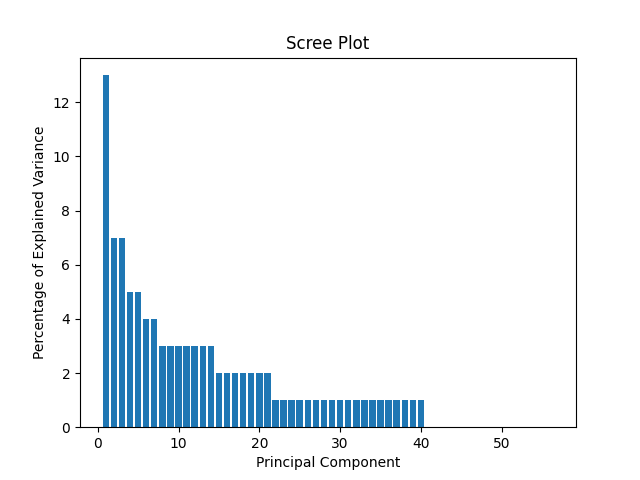

<IPython.core.display.Javascript object>


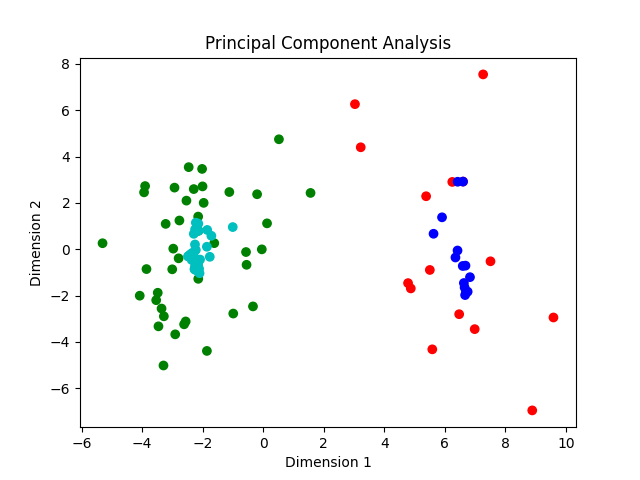

<IPython.core.display.Javascript object>


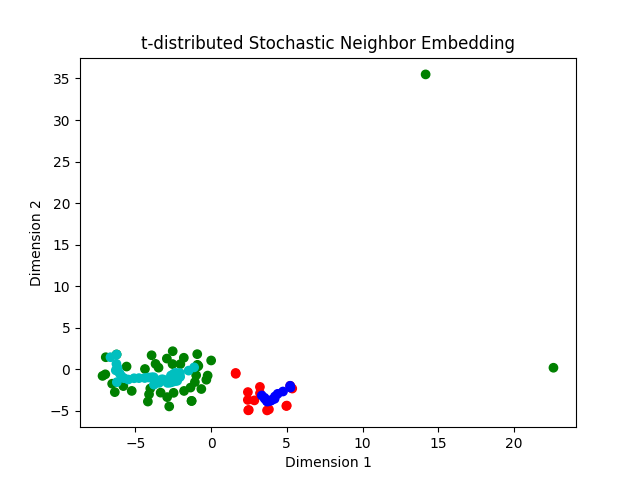

In [6]:
data = pd.DataFrame(x)

scaler = preprocessing.StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

pca = PCA()
pca.fit(scaled_data)

data_ = pd.DataFrame(x_)
scaled_data_ = scaler.transform(data_)

pca_data = pd.DataFrame(pca.transform(np.concatenate([scaled_data, scaled_data_])))
pca_data['label'] = y + y_

fig, ax = plt.subplots()
per_var = np.round(pca.explained_variance_ratio_ * 100)
ax.set_title('Scree Plot')
ax.set_ylabel('Percentage of Explained Variance')
ax.set_xlabel('Principal Component')
ax.bar(x = range(1, len(per_var) + 1), height = per_var)

fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'c']
labels_colors = {}
for label in pca_data['label']:
    if label not in labels_colors:
        labels_colors[label] = colors.pop(0)
colors = [labels_colors[label] for label in pca_data['label']]
ax.set_title('Principal Component Analysis')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.scatter(pca_data[0], pca_data[1], c = colors)

fig, ax = plt.subplots()
tsne = TSNE()
tsne_data = pd.DataFrame(tsne.fit_transform(np.concatenate([scaled_data, scaled_data_])))
ax.set_title('t-distributed Stochastic Neighbor Embedding')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.scatter(tsne_data[0], tsne_data[1], c = colors)

<IPython.core.display.Javascript object>


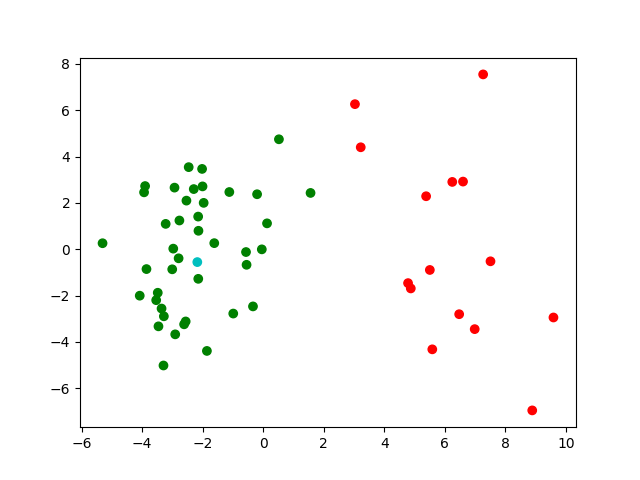

In [7]:
fig = plt.figure()
ims = []
for index, (x_i, y_i) in enumerate(zip(x_, y_)):
    data_ = pd.DataFrame([x_i])
    scaled_data_ = scaler.transform(data_)
    pca_data = pd.DataFrame(pca.transform(np.concatenate([scaled_data, scaled_data_])))
    pca_data['label'] = y + [y_i]
    im = plt.scatter(pca_data[0], pca_data[1], c = colors[:len(x)] + [colors[len(x) + index]], animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True, repeat_delay=1000)
plt.show()

In [8]:
from torch.utils.data import Dataset
import numpy

class Files_dataset(Dataset):
    def __init__(self,
                 files_segments,
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature='ivectors'):
        self.files_segments = files_segments
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.speakers_segments_indexes = {}
        self.speakers_segments_lengths = {}
        self.speakers_models = {}
        self.speakers_permutations = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_segments_lengths[file_id] = {}
            for speakers_names, indexes in self.speakers_segments_indexes[file_id].items():
                self.speakers_segments_lengths[file_id][speakers_names] = len(indexes)
            self.speakers_segments_lengths[file_id]['0'] = max(self.speakers_segments_lengths[file_id].values())
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                models_generation_lengths)
            self.speakers_permutations[file_id] = get_speakers_permutations(self.speakers_models[file_id],
                                                                            models_container_length,
                                                                            include_zeros,
                                                                            include_overlaps)
            for index, permutation in enumerate(self.speakers_permutations[file_id]):
                models_length = numpy.prod([len(self.speakers_models[file_id][speakers_names].keys())\
                if speakers_names != '0' else 1 for speakers_names in permutation])
                length = models_length * len(segments)
                self.lookup.append({\
                                    'file_id': file_id,\
                                    'permutation_index': index,\
                                    'models_length': models_length,\
                                    'segments_length': len(segments),\
                                    'permutation_length': length,\
                                    'onset': self.length,\
                                    'end': self.length + length - 1 })
                self.length += length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        lookup = [value for value in self.lookup if value['onset'] <= idx and idx <= value['end']][0]
        index = idx - lookup['onset']
        permutation = self.speakers_permutations[lookup['file_id']][lookup['permutation_index']]
        remainder, segment_index = divmod(index, lookup['segments_length'])
        models_container = []
        for index, speakers_names in enumerate(permutation):
            models_lengths = [len(self.speakers_models[lookup['file_id']][speakers_names].keys()) if speakers_names != '0' else 1 for speakers_names in permutation][index + 1:]
            if index != len(permutation) - 1:
                model_index, remainder = divmod(remainder, int(numpy.prod(models_lengths)))
            else:
                model_index = remainder
            if speakers_names != '0':
                models_container.append(self.speakers_models[lookup['file_id']][speakers_names][list(self.speakers_models[lookup['file_id']][speakers_names].keys())[model_index]])
            else:
                # TODO: improve
                models_container.append({ 'ivectors': [Ivector(numpy.random.uniform(-0.1, 0.1, 128).astype(numpy.float32))] })
        segment = self.files_segments[lookup['file_id']][segment_index]
        segment_speakers = [speaker.get_name() for speaker in segment.get_speakers()]
        x = [value[self.feature][0].get_value() for value\
             in models_container + [{ 'ivectors': segment.get_ivectors() }]]
        if self.include_overlaps:
            segment_speakers = ','.join(sorted(set(segment_speakers)))
            y = numpy.asarray([speakers_names == segment_speakers for speakers_names in permutation], dtype = numpy.float32)
        else:
            y = numpy.asarray([speakers_names in segment_speakers for speakers_names in permutation], dtype = numpy.float32) / len(segment_speakers)
        w = [self.speakers_segments_lengths[lookup['file_id']][speakers_names] for speakers_names in permutation]
        w_sum = np.sum(w)
        w = np.ones(len(w)) - w / w_sum
        return x, y, w

In [11]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear((b - 6) * M, M * 32),
            nn.ReLU(),
            nn.Linear(M * 32, M * 16),
            nn.ReLU(),
            nn.Linear(M * 16, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [14]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_dataset = Files_dataset(dev_files_segments_lim)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 8)

net = Model(128, 2).to(device, non_blocking = True)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

for epoch in range(10):
    losses = []
    for x, y, w in train_dataloader:
        x = [tensor.to(device, non_blocking = True) for tensor in x]
        y = y.to(device, non_blocking = True)
        w = w.to(device, non_blocking = True)
        
        criterion = nn.BCELoss(w)
        y_ = net(x)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data)
    print(np.sum(losses) / len(losses))

tensor(0.2847, device='cuda:0')
tensor(0.2588, device='cuda:0')
tensor(0.2527, device='cuda:0')
tensor(0.2419, device='cuda:0')
tensor(0.2358, device='cuda:0')
tensor(0.2293, device='cuda:0')
tensor(0.2243, device='cuda:0')
tensor(0.2195, device='cuda:0')
tensor(0.2156, device='cuda:0')
tensor(0.2137, device='cuda:0')
